## Sentiment Based Product Recommendation System.
In this notebook I am analysing the product reviews and building 4 ML models to get the sentiments corresponding to the users' reviews and ratings for multiple products. 
1. Logistic regression
2. Random forest
3. XGBoost
4. Naive Bayes

Then these 4 models are evaluated and based upon the performance, one best model is selected.

It includes :
Data cleaning steps
Text preprocessing
Feature extraction
ML models used to build sentiment analysis models
Class Imbalance
Two recommendation systems
Their evaluations.

# Reading the dataset

In [1]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [2]:
import pandas as pd
import seaborn as sns

In [3]:
#df=pd.read_csv('/content/gdrive/MyDrive/MyCapstone (1)/data/sample30.csv')
df=pd.read_csv('data/sample30.csv')

In [4]:
df.shape

(30000, 15)

In [5]:
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

# Data Analysis

In [7]:
print("Unique no. of items :",df.id.nunique())
print("Unique no. of users :",df.reviews_username.nunique())

Unique no. of items : 271
Unique no. of users : 24914


In [8]:
df.user_sentiment.value_counts()

Positive    26632
Negative     3367
Name: user_sentiment, dtype: int64

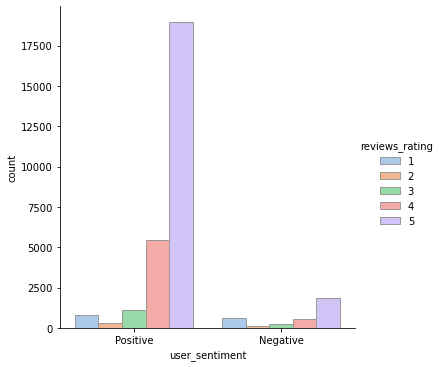

In [9]:
sns.catplot(x="user_sentiment", hue="reviews_rating", kind="count",
            palette="pastel", edgecolor=".6",
            data=df)

## Data Cleaning

In [10]:
df['reviews_didPurchase'].fillna("Not Purchased",inplace=True)
df['reviews_doRecommend'].fillna("Not Recommend",inplace=True)

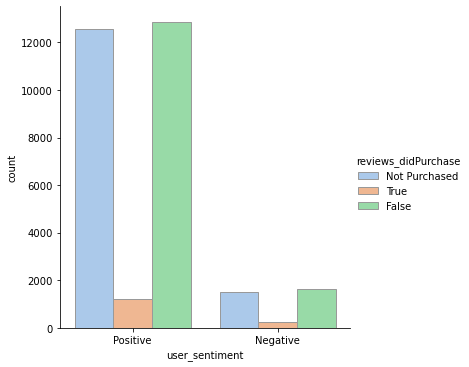

In [11]:
sns.catplot(x="user_sentiment", hue="reviews_didPurchase", kind="count",
            palette="pastel", edgecolor=".6",
            data=df)

Most of the people have not purchased the item but only reviewing it.

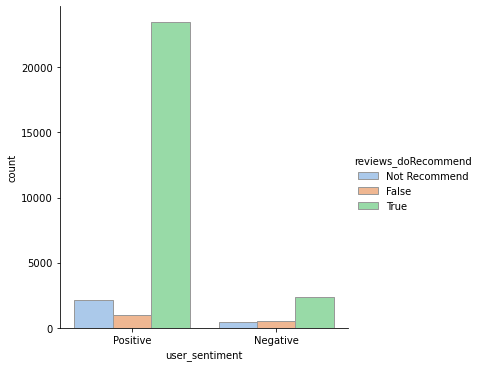

In [12]:
sns.catplot(x="user_sentiment", hue="reviews_doRecommend", kind="count",
            palette="pastel", edgecolor=".6",
            data=df)

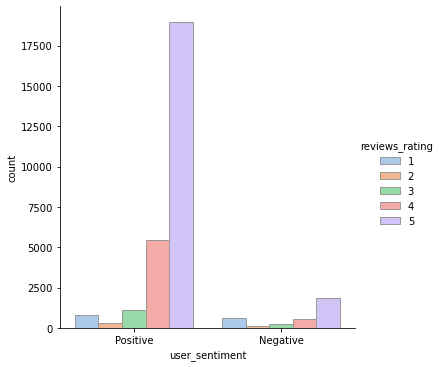

In [13]:
sns.catplot(x="user_sentiment", hue="reviews_rating", kind="count",
            palette="pastel", edgecolor=".6",
            data=df)

## Checking for missing values

In [14]:
df.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase         0
reviews_doRecommend         0
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

In [15]:
## Replacing NAN values with blank from reviews_title field
df.reviews_title = df.reviews_title.fillna('')

In [16]:
df = df[df['user_sentiment'].notna()]

# Building  Models

In [17]:
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import accuracy_score

In [18]:
all_text=df['reviews_title']+" "+df['reviews_text']

In [19]:
all_text.head()

0    Just Awesome i love this album. it's very good...
1    Good Good flavor. This review was collected as...
2                                    Good Good flavor.
3    Disappointed I read through the reviews on her...
4    Irritation My husband bought this gel for us. ...
dtype: object

In [20]:
y=df['user_sentiment']

In [21]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)
word_vectorizer.fit(all_text)
train_word_features = word_vectorizer.transform(all_text)

In [22]:
#char_vectorizer = TfidfVectorizer(
#    sublinear_tf=True,
#    strip_accents='unicode',
#    analyzer='char',
#    stop_words='english',
#    ngram_range=(2, 6),
#    max_features=50000)
#char_vectorizer.fit(all_text)
#train_char_features = char_vectorizer.transform(all_text)

#train_features = hstack([train_char_features, train_word_features])
train_features = train_word_features

Dividing test and train data set

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_features, y,test_size=0.3,random_state=101)

## Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()
classifier.fit(X_train,y_train)
preds=classifier.predict(X_test)

In [25]:
rf_accuracy=accuracy_score(preds,y_test)

In [26]:
print("Random Forest model accuracy : ",round((rf_accuracy*100),2),"%")

Random Forest model accuracy :  91.08 %


## XGBoost

In [27]:
import xgboost as xgb
xgb=xgb.XGBClassifier()
xgb.fit(X_train,y_train)

C:\Users\LPT-2347\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:32:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [28]:
preds2=xgb.predict(X_test)

In [29]:
xgb_accuracy=accuracy_score(preds2,y_test)

In [30]:
print("XGBoost model accuracy : ",round((xgb_accuracy*100),2),"%")

XGBoost model accuracy :  91.63 %


## Logistic regression

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

In [32]:
clf = LogisticRegression().fit(X_train, y_train)
clf_pred = clf.predict(X_test)
accuracy = clf.score(X_test, y_test)

In [33]:
model_performance = classification_report(y_test, clf_pred)
print("Logistic regression model accuracy : ",round((accuracy*100),2),"%")

Logistic regression model accuracy :  91.04 %


In [34]:
print(model_performance)

              precision    recall  f1-score   support

    Negative       0.82      0.23      0.36       986
    Positive       0.91      0.99      0.95      8014

    accuracy                           0.91      9000
   macro avg       0.87      0.61      0.66      9000
weighted avg       0.90      0.91      0.89      9000



## Naive Bayes

In [35]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

In [36]:
def model_predict(X_train, y_train, X_test, y_test, ml_model):
    
    clf = ml_model.fit(X_train, y_train)
    clf_pred = clf.predict(X_test)
    accuracy = clf.score(X_test, y_test)
    model_performance = classification_report(y_test, clf_pred)
    validation_pred_proba_grad = clf.predict_proba(X_test)
    roc_auc = roc_auc_score(y_test, validation_pred_proba_grad[:,1])
    
    print (' model accuracy : ',round((accuracy*100),2),"%")
    print('')
    print(model_performance)
    print('')
    print('ROC_AUC score: ', roc_auc)
    return accuracy

In [37]:
MultinomialNB_accuracy = model_predict(X_train, y_train, X_test, y_test, MultinomialNB())

 model accuracy :  89.08 %

              precision    recall  f1-score   support

    Negative       0.54      0.02      0.04       986
    Positive       0.89      1.00      0.94      8014

    accuracy                           0.89      9000
   macro avg       0.71      0.51      0.49      9000
weighted avg       0.85      0.89      0.84      9000


ROC_AUC score:  0.8011274387468987


In [38]:
BernoulliNB_accuracy = model_predict(X_train, y_train, X_test, y_test, BernoulliNB())

 model accuracy :  86.34 %

              precision    recall  f1-score   support

    Negative       0.35      0.29      0.32       986
    Positive       0.91      0.93      0.92      8014

    accuracy                           0.86      9000
   macro avg       0.63      0.61      0.62      9000
weighted avg       0.85      0.86      0.86      9000


ROC_AUC score:  0.8179147445317551


# Handling Class Imbalance

Let's check if there is any class imbalance here. If there is any class imbalance, then I will resolve that issue and will run the model again and will check the model performance.

In [39]:
y.value_counts()

Positive    26632
Negative     3367
Name: user_sentiment, dtype: int64

If we check the above value counts, the target values are skewed towards positive side. In order to address this issue, resampling the data has to be performed. I will use oversampling to combat class imbalance. Smote is especially preferable since it's a well-made package with it's own pipeline function compatible with other python modules. Also, before applying SMOTE technique to balance the class, I would like lemmatize the review text and pass it to TFIDF vectorizer.

In [40]:
from imblearn.over_sampling import SMOTE

In [41]:
sm = SMOTE()
X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)
X_test_smote, y_test_smote = sm.fit_sample(X_test, y_test)

AttributeError: 'SMOTE' object has no attribute 'fit_sample'

In [ ]:
#Logistic Regression
model_predict(X_train_smote, y_train_smote, X_test_smote, y_test_smote, LogisticRegression())


In [ ]:
#MultinomialNB
model_predict(X_train_smote, y_train_smote, X_test_smote, y_test_smote, MultinomialNB())

In [ ]:
#BernoulliNB
model_predict(X_train_smote, y_train_smote, X_test_smote, y_test_smote, BernoulliNB())

Model performance degrades after using SMOTE, so we are not using SMOTE in our final model deployment.

## Comparing Models

In [42]:
print("Random Forest model accuracy : ",round((rf_accuracy*100),2),"%")
print("XGBoost model accuracy : ",round((xgb_accuracy*100),2),"%")
print("Logistic regression model accuracy : ",round((accuracy*100),2),"%")
print("MultinomialNB model accuracy : ",round((MultinomialNB_accuracy*100),2),"%")
print("BernoulliNB model accuracy : ",round((BernoulliNB_accuracy*100),2),"%")

Random Forest model accuracy :  91.08 %
XGBoost model accuracy :  91.63 %
Logistic regression model accuracy :  91.04 %
MultinomialNB model accuracy :  89.08 %
BernoulliNB model accuracy :  86.34 %


Logistic regression model is the best performing model among all models, with the accuracy of approx. 91%

I will use Logistic regression model as my final model for deployment